**This notebook introduces how to apply gaussian process to predict the global temperature. <br/>**


Reference: https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/ClimateBenchGP_tas.ipynb

**Note:** You would need the `gpflow` package to run this notebook. `gpflow` is built upon tensorflow and is widely used to build Gaussian process models in python.

You can use `conda install -c conda-forge gpflow` to install it.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'train_val')
test_path  = os.path.join(cwd,'test')

make_dir(train_path)
make_dir(test_path)

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [4]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

#### Data standardization

In [5]:
# Standardize the predictors
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test  = X_test_df.to_numpy()


In [6]:
# Standardize the predictand 
y_train    = y_train_df.to_numpy().astype(np.float64)
train_tas_mean, train_tas_std = y_train.mean(), y_train.std()
y_train    = (y_train - train_tas_mean) / train_tas_std


print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


### 2. Build & train the Gaussian process model

In [7]:
# Define the kernels
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel = kernel_CO2 + kernel_CH4

# Define the model
np.random.seed(5)
mean  = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train, y_train),
                          kernel=kernel,
                          mean_function=mean)

# Define optimizer
opt = gpflow.optimizers.Scipy()

2022-10-24 18:42:07.583674: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-10-24 18:42:17.218229: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06006D+07    |proj g|=  2.80826D+06

At iterate    1    f=  4.73146D+06    |proj g|=  1.29388D+06

At iterate    2    f=  4.48439D+06    |proj g|=  1.39230D+05

At iterate    3    f=  4.48098D+06    |proj g|=  4.11743D+04

At iterate    4    f=  4.47600D+06    |proj g|=  3.79044D+04

At iterate    5    f=  4.44283D+06    |proj g|=  9.45750D+04

At iterate    6    f=  4.43476D+06    |proj g|=  4.39758D+04

At iterate    7    f=  4.43287D+06    |proj g|=  9.47256D+03

At iterate    8    f=  4.43243D+06    |proj g|=  1.09219D+04

At iterate    9    f=  4.43155D+06    |proj g|=  2.74722D+04

At iterate   10    f=  4.42973D+06    |proj g|=  4.38836D+04

At iterate   11    f=  4.42647D+06    |proj g|=  4.75246D+04

At iterate   12    f=  4.42093D+06    |proj g|=  3.68952D+03

At iterate   13    f=  4.4

      fun: 4401108.245389249
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.15241667,  1.62600603,  5.05585109, -2.96332988,  0.46572239,
        3.04284268])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 47
      nit: 36
     njev: 47
   status: 0
  success: True
        x: array([ 5.01687833,  4.59160975, -1.23551482, -3.49155934, -2.00813842,
        0.82742154])

### 3. Evaluate the model

In [9]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test)
posterior_mean   = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_tas_std

In [10]:
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                                 'latitude': X_test_xr.latitude.values, 
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

In [11]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.3030845450775347
RMSE at 2100: 0.3297314447829202
RMSE 2045-2055: 0.34500836872000656
RMSE 2090-2100: 0.3617038840758118
RMSE 2050-2100: 0.360498669633777
RMSE average last 20y: 0.1679149045931111


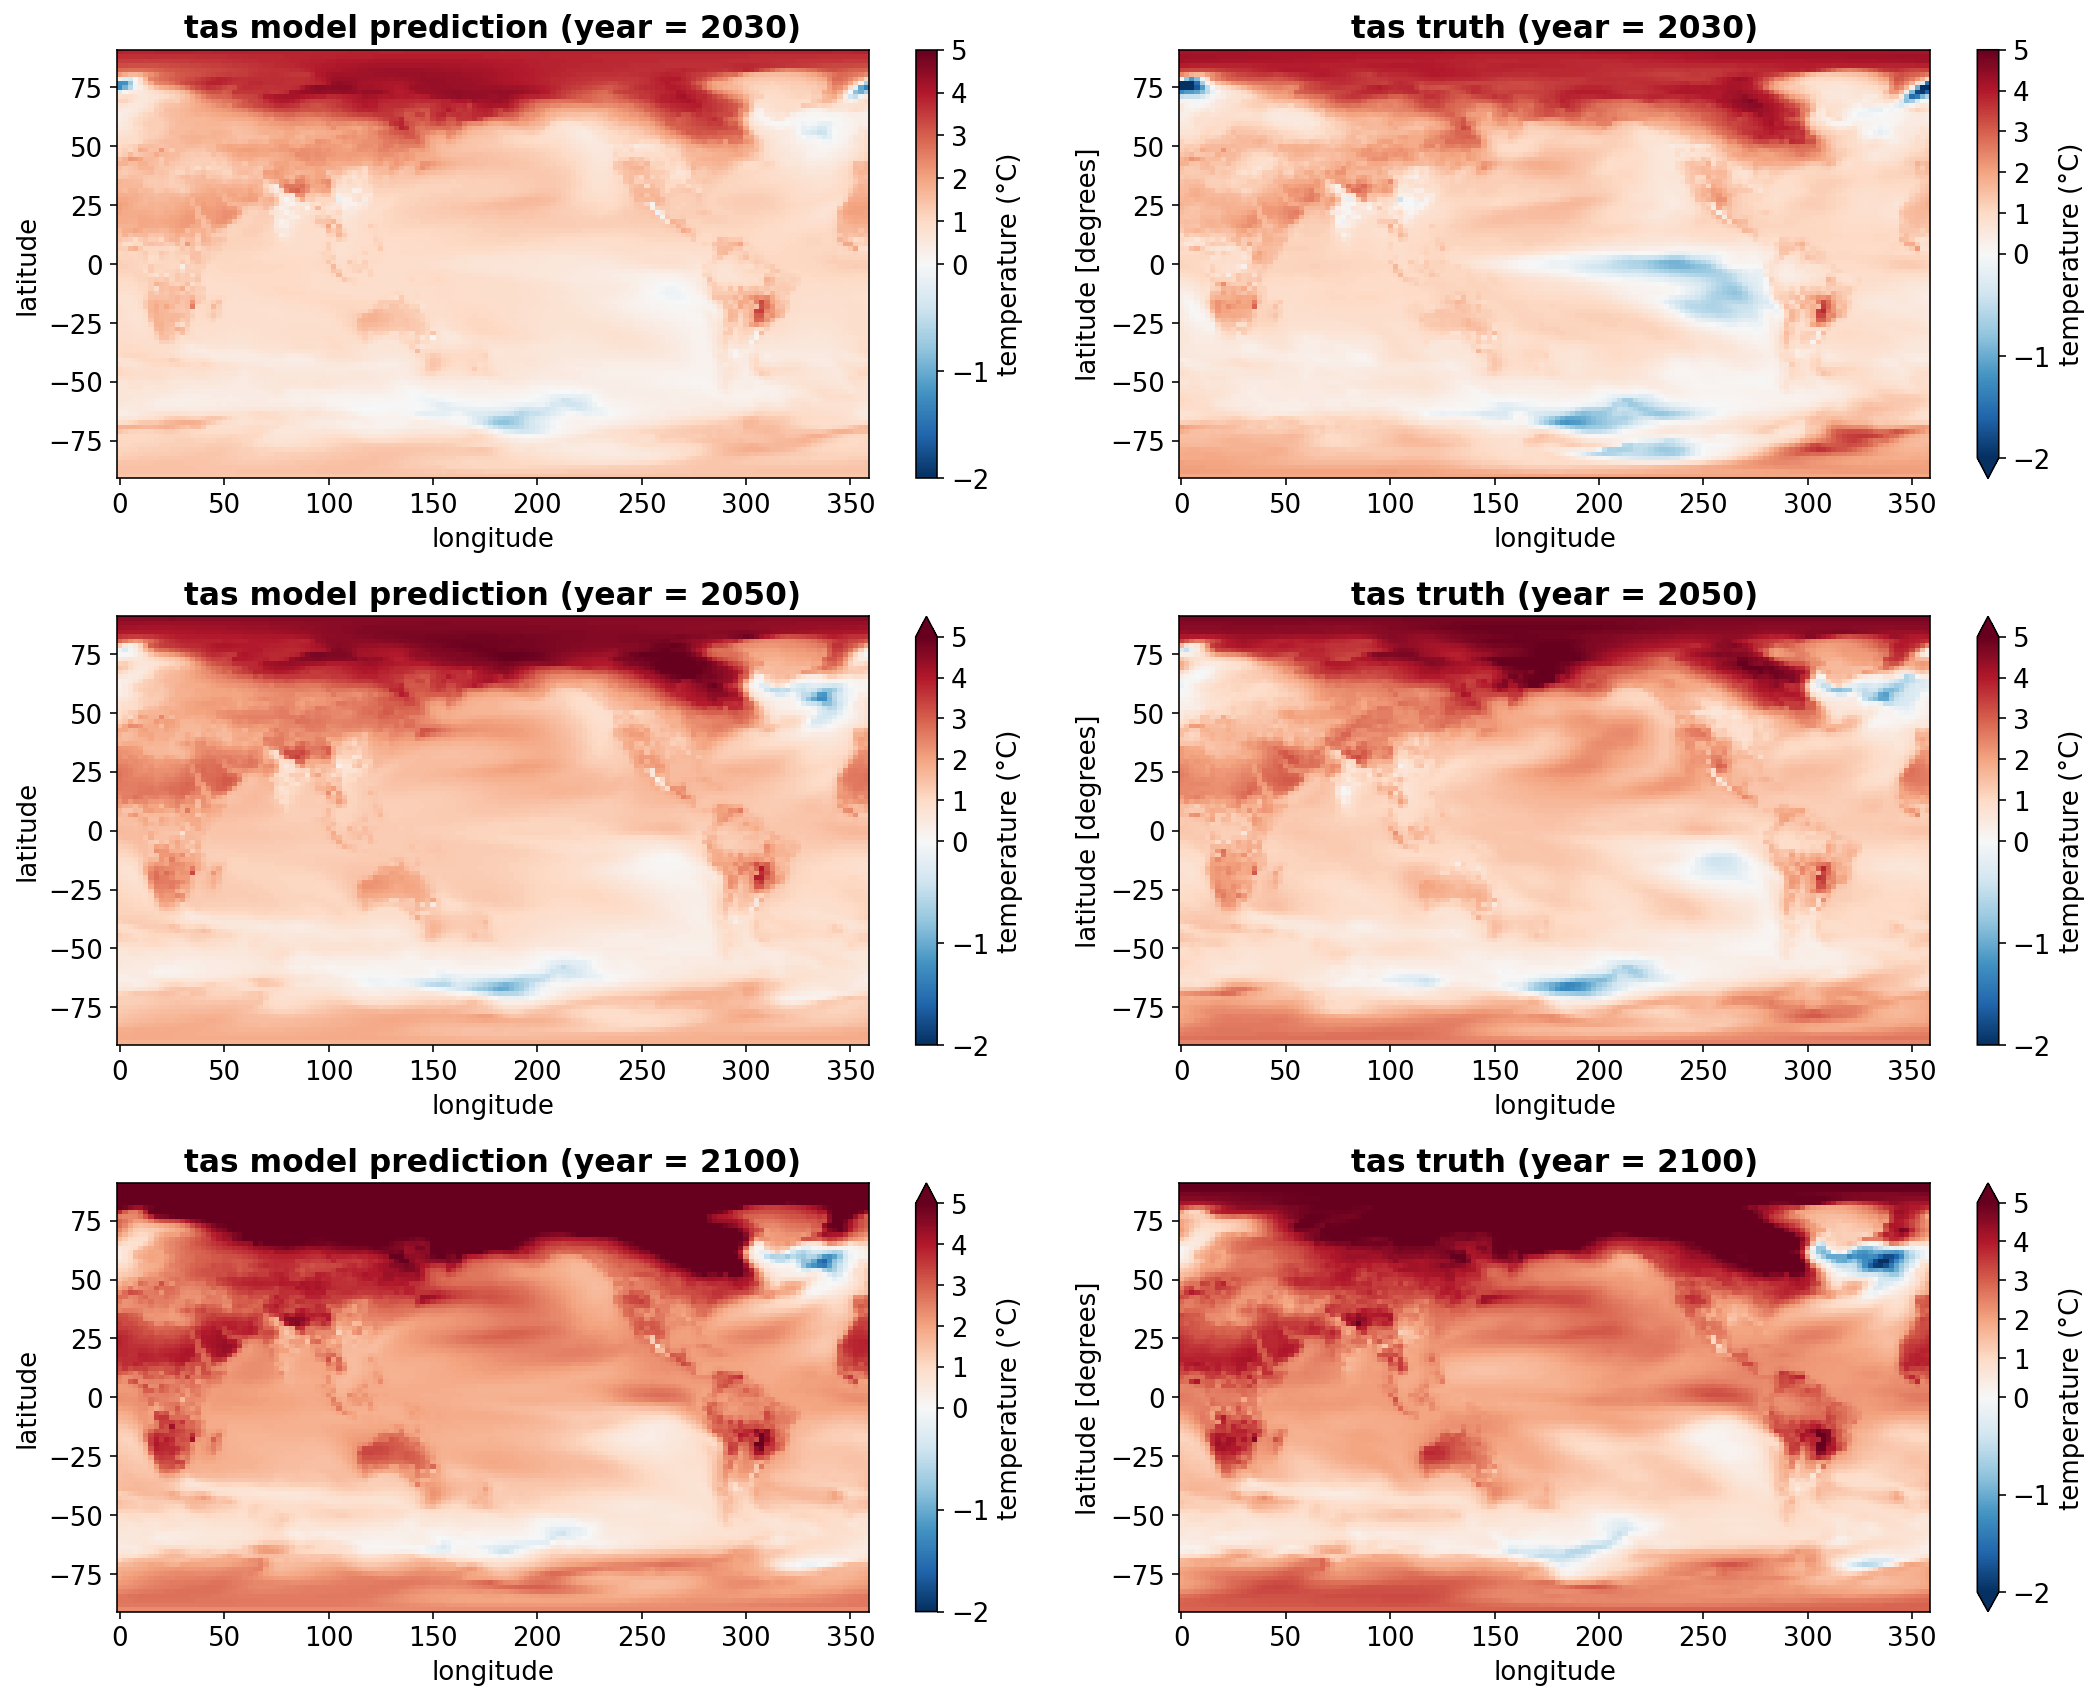

In [12]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

y_test_pre.tas_mean.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()